# Understanding Movies Using LSA

In [1]:
import numpy as np
import pandas as pd
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

% matplotlib inline

## Loading the Data

I've left the data in single files for each year, so that an enthusiastic person of the future could add extra years' data easily.

In [2]:
dfs = []
for year in range(1940, 2018):
    dfs.append(pd.read_csv('scraped_movies/top_movies_of_%d.csv' % year, encoding = 'cp1252'))
movie_data = pd.concat(dfs)

In [3]:
dfs = []
for year in range(1940, 2018):
    dfs.append(pd.read_csv('scraped_movies/keywords_for_top_movies_of_%d.csv' % year, encoding = 'cp1252'))
keywords = pd.concat(dfs)

In [4]:
movie_data.index = range(len(movie_data))
keywords.index = range(len(keywords))

In [5]:
movie_data.head()

,IMDbId,IMDb_score,box_office_rank,genre_list,release_year,title
0,tt0032910,7.5,1.0,"Animation, Comedy, Family",1940,Pinocchio (1940)
1,tt0032455,7.8,2.0,"Animation, Family, Fantasy",1940,Fantasia (1940)
2,tt0032384,6.8,3.0,Drama,1940,De Mayerling ï¿½ Sarajevo (1940)
3,tt0032976,8.2,4.0,"Drama, Mystery, Romance",1940,Rebecca (1940)
4,tt0032553,8.5,5.0,"Comedy, Drama, War",1940,The Great Dictator (1940)


In [6]:
keywords.head()

,IMDbId,keywords
0,tt0032910,italy|pinocchio|jiminy-cricket|puppet|conscien...
1,tt0032455,classical-music|disney|mouse|orchestra|apprent...
2,tt0032384,NaN
3,tt0032976,bride|widower|estate|monte-carlo|housekeeper|w...
4,tt0032553,invented-language|dual-role|fictitious-country...


We can see there's some movies missing keywords, and probably a bunch of missing data elsewhere too. I'm basically ignoring that at the moment.

## Lookup objects

For convenience, I'm defining here a bunch of lookups I'll later use to filter the datasets - they're mostly boolean series, or dicts.

In [7]:
marvel_lookup = keywords.keywords.fillna('').str.contains('marvel-cinematic-universe')

In [8]:
title_lookup = pd.Series(movie_data.title)
title_lookup.index = movie_data.IMDbId
title_lookup = title_lookup.to_dict()




In [9]:
furiouses = ['The Fast and the Furious (2001)',
'2 Fast 2 Furious (2003)',
'The Fast and the Furious: Tokyo Drift (2006)',
'Fast & Furious (2009)',
'Fast Five (2011)',
'Furious 6 (2013)',
'Furious Seven (2015)',
'The Fate of the Furious (2017)']

furious_lookup = keywords.IMDbId.map(title_lookup).isin(furiouses)

In [10]:
aliens = ['Alien (1979)',
          'Aliens (1986)',
          'Alien³ (1992)',
          'Alien Resurrection (1997)',
          'AVP: Alien vs. Predator (2004)',
          'Prometheus (I) (2012)',
          'Alien: Covenant (2017)'
]

aliens_lookup = keywords.IMDbId.map(title_lookup).isin(aliens)

In [11]:
princess_lookup = keywords.keywords.fillna('').str.contains('disney-princess')

In [12]:
jaws_lookup = keywords.IMDbId.map(title_lookup).apply(lambda x: 'jaws' in x.lower())

In [13]:


decade_lookup = pd.DataFrame(movie_data.release_year.apply(lambda x: math.floor(x/10)*10))
decade_lookup.index = movie_data.IMDbId
decade_lookup = decade_lookup.to_dict()['release_year']

In [14]:
chocula = CountVectorizer(tokenizer = lambda x: x.split(', '))
genres = chocula.fit_transform(movie_data.genre_list.fillna('xxx')).toarray()
genre_lookup = pd.DataFrame(genres, columns = chocula.get_feature_names())
genre_lookup.index = movie_data.IMDbId

In [15]:
rank_lookup = pd.Series(movie_data.box_office_rank)
rank_lookup.index = movie_data.IMDbId
rank_lookup = rank_lookup.to_dict()


## Process Example

I'm running through the whole transformation with a sample of the data, to demonstrate what it looks like at each stage.

We're transforming our list of movies and keywords into a list of movies and a set of columns storing an abstract numeric represenation of that movie, derived from its similarity to other movies, in terms of their shared keywords. The steps are:

- "Bag of words" encoding - making a table with a column for each keyword
- "TFIDF" weighting - weighting each movie's keyword entries to account for movies with more or fewer total keywords
- Taking the "Dot Product" - Creating a matrix comparing each movie to each other movie, in terms of keyword similarity.
- Applying "Dimensionality Reduction" - reducing the number of columns in the matrix from one per movie to a smaller number of abstract values.

In [16]:
sample = keywords[(keywords.IMDbId.map(rank_lookup) < 10)& # Make sure they're movies someone has heard of
                  (keywords.IMDbId.map(title_lookup).apply(len) < 25)  # Make sure the title's aren't too long to display nicely
                 ].sample(10)

pd.DataFrame([sample.IMDbId.map(title_lookup), 
              sample.keywords.apply(lambda x: ', '.join(str(x).split('|')))]).transpose()

,IMDbId,keywords
4608,Ruthless People (1986),"kidnapping, ransom, extramarital-affair, polic..."
1408,Dial M for Murder (1954),"blackmail, murder, letter, writer, marriage, e..."
602,Duel in the Sun (1946),"half-breed, infidelity, extramarital-affair, b..."
903,White Heat (1949),"psychopath, transmitter, oscillator, trojan-ho..."
3306,Lost Horizon (1973),"based-on-novel, shangri-la, diplomat, remake, ..."
7203,Skyfall (2012),"007, terrorist-cell, intelligence-agency, comp..."
5703,Liar Liar (1997),"birthday-wish, female-stockinged-feet, pantyho..."
2406,Kissin' Cousins (1964),"foot-fetish, lookalike, identical-cousins, son..."
604,The Yearling (1946),"boy, deer, fawn, pet, death, children, florida..."
4304,WarGames (1983),"game, computer, norad, teenager, high-school, ..."


### Bag of Words

Creating a "Countvectoriser" object, and a "TfidifTransformer", which will do bag-of-words encoding and TFIDF weighting, respectively.

In [17]:
vlad = CountVectorizer(tokenizer = lambda x: x.split('|'), min_df = 0)

megatron = TfidfTransformer()

sparse = vlad.fit_transform(pd.Series(keywords.keywords.fillna('').values))
sample_sparse = vlad.fit_transform(pd.Series(sample.keywords.fillna('').values))

Choose some random columns to show

In [18]:
ns = random.sample(range(len(vlad.get_feature_names())), 5)

The sample dataset has been "bag of words" encoded - we've created a column for each keyword, and each movie gets a flag for whether it has that keyword or not.

In [19]:
pd.DataFrame(sample_sparse.toarray()[:,ns], index=sample.IMDbId.map(title_lookup), columns=[vlad.get_feature_names()[i] for i in ns])

,save-the-world,warrior,haunted-by-the-past,writing-on-a-mirror,shoot-the-lock
IMDbId,,,,,
Ruthless People (1986),0,0,0,0,0
Dial M for Murder (1954),0,0,0,0,0
Duel in the Sun (1946),0,0,0,0,0
White Heat (1949),0,0,0,1,1
Lost Horizon (1973),0,0,0,0,0
Skyfall (2012),1,1,1,0,0
Liar Liar (1997),0,0,0,0,0
Kissin' Cousins (1964),0,0,0,0,0
The Yearling (1946),0,0,0,0,0


 ### TFIDF Weighting
 
 Now we apply the TFIDF weighting.

In [20]:
weighted = megatron.fit_transform(sample_sparse)

pd.DataFrame(weighted.toarray()[:,ns], index=sample.IMDbId.map(title_lookup), columns=[vlad.get_feature_names()[i] for i in ns]).apply(round, args=(2,))

,save-the-world,warrior,haunted-by-the-past,writing-on-a-mirror,shoot-the-lock
IMDbId,,,,,
Ruthless People (1986),0.00,0.00,0.00,0.00,0.00
Dial M for Murder (1954),0.00,0.00,0.00,0.00,0.00
Duel in the Sun (1946),0.00,0.00,0.00,0.00,0.00
White Heat (1949),0.00,0.00,0.00,0.07,0.07
Lost Horizon (1973),0.00,0.00,0.00,0.00,0.00
Skyfall (2012),0.06,0.06,0.06,0.00,0.00
Liar Liar (1997),0.00,0.00,0.00,0.00,0.00
Kissin' Cousins (1964),0.00,0.00,0.00,0.00,0.00
The Yearling (1946),0.00,0.00,0.00,0.00,0.00


### Dot Product

Now we take the "Dot product" of the weighted values - every movie's correlation with every other movie, in terms of keywords in common.

In [21]:
# Cheeky wee method for shading the dataframe nicely. Pretty sure I nicked this offa StackOverflow.

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

In [22]:
weighted = megatron.fit_transform(sparse)
the_matrix = weighted.dot(weighted.T)
the_matrix = the_matrix[:,sample.index][sample.index,:]
dot = pd.DataFrame(the_matrix.toarray(), index=sample.IMDbId.map(title_lookup), columns=sample.IMDbId.map(title_lookup)).apply(round, args=(2,))
dot.style.apply(background_gradient,
               cmap=sns.light_palette("grey", as_cmap=True),
               m=dot.min().min(),
               M=0.05,
               low=0)


IMDbId,Ruthless People (1986),Dial M for Murder (1954),Duel in the Sun (1946),White Heat (1949),Lost Horizon (1973),Skyfall (2012),Liar Liar (1997),Kissin' Cousins (1964),The Yearling (1946),WarGames (1983)
IMDbId,,,,,,,,,,
Ruthless People (1986),1,0.03,0.03,0.03,0.01,0.02,0.01,0,0.01,0.04
Dial M for Murder (1954),0.03,1,0.02,0.03,0.01,0.02,0.01,0.02,0.02,0
Duel in the Sun (1946),0.03,0.02,1,0.01,0.01,0,0.02,0.02,0.01,0
White Heat (1949),0.03,0.03,0.01,1,0,0.06,0.01,0.01,0.01,0.01
Lost Horizon (1973),0.01,0.01,0.01,0,1,0.01,0.01,0.04,0.02,0.02
Skyfall (2012),0.02,0.02,0,0.06,0.01,1,0.01,0,0.02,0.02
Liar Liar (1997),0.01,0.01,0.02,0.01,0.01,0.01,1,0,0.01,0
Kissin' Cousins (1964),0,0.02,0.02,0.01,0.04,0,0,1,0.02,0.02
The Yearling (1946),0.01,0.02,0.01,0.01,0.02,0.02,0.01,0.02,1,0


### Dimensionality Reduction

Finally, we apply dimensionality reduction. I'm using "Non-negative matrix factorization", because the similarity calculations I'm doing later - cosine similarity - get weird if there are negative values. I'm not convinced this is the right approach though.

In [23]:
shrinky = NMF(n_components = 2)

shrunk_sample = shrinky.fit_transform(the_matrix.toarray())

In [24]:

reduced = pd.DataFrame(shrunk_sample, index=sample.IMDbId.map(title_lookup)).apply(round, args=(2,))

reduced.style.apply(background_gradient,
               cmap=sns.light_palette("grey", as_cmap=True),
               m=reduced.min().min(),
               M=reduced.max().max(),
               low=0)


,0,1
IMDbId,,
Ruthless People (1986),0.46,0
Dial M for Murder (1954),0.36,0.04
Duel in the Sun (1946),0.09,0.3
White Heat (1949),0.52,0
Lost Horizon (1973),0,0.69
Skyfall (2012),0.48,0
Liar Liar (1997),0.13,0.17
Kissin' Cousins (1964),0,0.68
The Yearling (1946),0,0.58


## Apply to the Whole Dataset

In [94]:
# Throwing the whole process into a little method

def make_matrix(df, countvectoriser, tfidf): 
    sparse = countvectoriser.fit_transform(pd.Series(df.keywords.fillna('').values))
    weighted = tfidf.fit_transform(sparse)    
    matrix = weighted.dot(weighted.T)
    movies = pd.Series(countvectoriser.get_feature_names())
    return matrix, movies, weighted

In [95]:

vlad_ = CountVectorizer(tokenizer = lambda x: x.split('|'), min_df = 10)
megatron_ = TfidfTransformer()
matrix, words, weighted = make_matrix(keywords, vlad_, megatron_)

In [96]:
target = matrix[10].toarray()

In [97]:
vector = megatron_.transform(vlad_.transform([keywords.loc[10].keywords]))

In [98]:
vector

<1x10635 sparse matrix of type '<class 'numpy.float64'>'
	with 83 stored elements in Compressed Sparse Row format>

In [107]:
new = weighted.dot(vector.T).toarray().T

I'm keeping the dimensionality reduction seperate, 'cause it's SLOW.

In [26]:
shrinky = NMF(n_components = 100)

shrunk_100 = shrinky.fit_transform(matrix.toarray())

Visualising the sample from above, but with the full set of columns.

In [27]:
reduced = pd.DataFrame(shrunk_100[sample.index,:15], index=sample.IMDbId.map(title_lookup)).apply(round, args=(2,))
reduced['...'] = pd.Series(['']*10, index = sample.IMDbId.map(title_lookup))
reduced.style.apply(background_gradient,
                    subset=pd.IndexSlice[:,range(0, 15)],
               cmap=sns.light_palette("grey", as_cmap=True),
               m=reduced[[i for i in range(0,10)]].min().min(),
               M=reduced[[i for i in range(0,10)]].max().max(),
               )


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...
IMDbId,,,,,,,,,,,,,,,,
Up (2009),0.03,0,0.11,0.02,0.01,0,0.02,0,0,0,0.02,0,0,0.01,0,
The Yearling (1946),0,0,0.03,0,0.01,0,0,0.03,0,0,0.08,0,0,0.01,0,
Vivere in pace (1947),0,0,0.01,0,0,0,0,0,0,0,0,0.19,0,0,0,
Romeo and Juliet (1968),0,0,0,0.13,0.01,0.04,0,0,0,0.11,0.1,0,0,0.04,0,
The Da Vinci Code (2006),0.06,0,0.03,0.01,0.02,0,0,0.02,0.02,0,0,0,0,0.01,0,
Platoon (1986),0,0,0,0.03,0.03,0,0,0,0,0,0,0,0.03,0.07,0,
Batman (1943),0,0,0,0.01,0.03,0.03,0.16,0,0,0,0,0.05,0,0.07,0,
G.I. Blues (1960),0.01,0,0.01,0,0,0,0,0,0,0,0,0.01,0,0.01,0.01,
Pinky (1949),0,0,0,0,0,0.04,0,0.04,0,0,0,0,0,0,0,


## Doing some Movie Maths!

In [80]:
movie_one = list(keywords.IMDbId.map(title_lookup)).index("Universal Soldier (1992)")

In [81]:
movie_two = list(keywords.IMDbId.map(title_lookup)).index("Piranha (1978)")

In [82]:
avg_movie = shrunk_100.mean(axis=0).reshape(1, -1)

In [83]:
targets = [movie_one, movie_two] #, 4225]

In [84]:
target =  shrunk_100[movie_one].reshape(1, -1) + shrunk_100[movie_two].reshape(1, -1)

In [85]:
best_list = [i for i in np.argsort(cosine_similarity(target, shrunk_100))[0][::-1] if i not in targets][:10]

[keywords.IMDbId.map(title_lookup)[i] for i in best_list]

['Missing in Action (1984)',
 'First Blood (1982)',
 'Rambo (2008)',
 'Scanners (1981)',
 'The Crazies (1973)',
 'Predator (1987)',
 'Doom (2005)',
 'Broken Arrow (1996)',
 'Night of the Living Dead (1968)',
 'The Incredible Hulk (2008)']

## Plotting movies

In [276]:
plotting_matrix = matrix

similar_matrix = plotting_matrix[aliens_lookup[aliens_lookup == True].index]

axis_1_title = 'Bambi (1942)'
axis_2_title = "Showgirls (1995)"

axis_1_movie = list(keywords.IMDbId.map(title_lookup)).index(axis_1_title)

axis_2_movie = list(keywords.IMDbId.map(title_lookup)).index(axis_2_title)


In [277]:
titles = keywords[aliens_lookup].IMDbId.map(title_lookup)

In [119]:
titles

NameError: name 'titles' is not defined

In [279]:
axis_1 = cosine_similarity(plotting_matrix[axis_1_movie], similar_matrix)[0]
axis_2 = cosine_similarity(plotting_matrix[axis_2_movie], similar_matrix)[0]

In [280]:
# An extremely janky method for stopping the titles from overlapping each other.

def avoid_overlap(axis_1, 
                  axis_2,
                  x_tolerance = 0.05,
                  y_tolerance = 0.02,
                  increment = 0.01):
    fixed = []
    for x, y in zip(axis_1, axis_2):
        Xs = pd.Series([i[0] for i in fixed])
        Ys = pd.Series([i[1] for i in fixed])
        while ((Xs < x+x_tolerance) & (Xs > x-x_tolerance) & (Ys < y+y_tolerance) & (Ys > y-y_tolerance)).any():
            y += y_tolerance
        fixed.append((x, y))
    return fixed
        



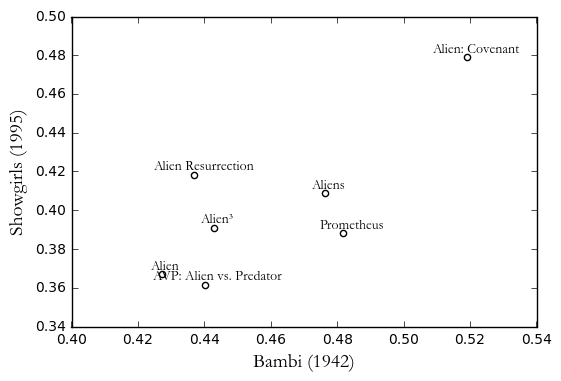

In [287]:
pd.DataFrame(list(zip(axis_1, axis_2))).plot(kind='scatter', x=0, y=1, c='w')

# Cause I'm lazy, you gotta fiddle with the values to get the titles to show up in the right spots.

for label, (x, y) in zip(list(titles.values), avoid_overlap(axis_1, 
                                                      axis_2, 
                                                      y_tolerance = 0.0006,
                                                      increment = 0.00002,
                                                     x_tolerance = 1)):
    label = label[:label.find('(')-1]
    plt.annotate(label,
                 fontsize=10,
                 fontname='Garamond',
                xy=(x - (len(label)*0.0007), y + 0.0025))
plt.xlabel(axis_1_title, fontname='Garamond', fontsize = 14)
plt.ylabel(axis_2_title, fontname='Garamond', fontsize = 14)
# plt.xlim(0.55, 0.78)
plt.show()

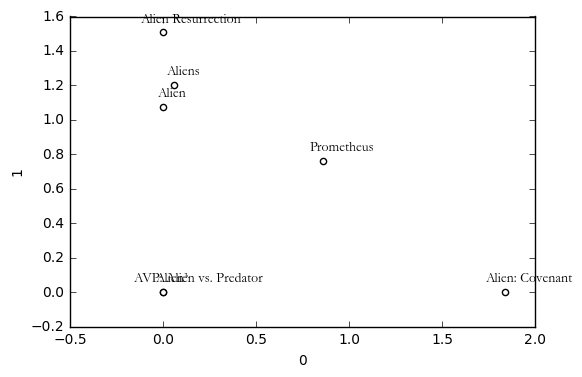

In [240]:
two_shrunk_two_furious = NMF(n_components = 4)

shrunk_2 = two_shrunk_two_furious.fit_transform(matrix[aliens_lookup[aliens_lookup == True].index].toarray())

alien_df = pd.DataFrame(shrunk_2)

alien_df.plot(kind='scatter', x=0, y=1, c='w')
for label, x, y in zip(list(titles.values), alien_df[0], alien_df[1]):
    label = label[:label.find('(')-1]
    plt.annotate(label,
                 fontsize=10,
                 fontname='Garamond',
                 xy =(x - (len(label)*0.007), y + 0.06))
plt.show()

In [241]:
alien_df.index = titles
alien_df.index.name = 'Title'
alien_df.style.apply(background_gradient,
                    subset=pd.IndexSlice[:,range(0, 5)],
               cmap=sns.light_palette("grey", as_cmap=True),
               m=0.05,
               M=2,
               )

C:\Users\simon.carryer\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\io\formats\style.py:511: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  data = self.data.loc[subset]
C:\Users\simon.carryer\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
C:\Users\simon.carryer\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
C:\

,0,1,2,3
Title,,,,
Alien (1979),0,1.07466,0,0.817128
Aliens (1986),0.0570134,1.20313,0.495328,0.442488
Alien³ (1992),0,0,0.322712,1.52612
Alien Resurrection (1997),0,1.50743,0.521739,0
AVP: Alien vs. Predator (2004),0,0,1.93856,0.045044
Prometheus (I) (2012),0.857568,0.763227,0,0.0738052
Alien: Covenant (2017),1.83695,0,0.113477,0


In [214]:
[(label, x, y) for label, x, y in zip(list(titles.values), shrunk_2[0], shrunk_2[1])]

[('Alien (1979)', 0.0, 0.32869353140190521),
 ('Aliens (1986)', 0.92728398608709284, 1.1366325863284708),
 ('Alien³ (1992)', 0.0, 0.48841624022684982),
 ('AVP: Alien vs. Predator (2004)', 1.0498352089732472, 0.10050532081262395)]